In [3]:
import PyPDF2 as pdf
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.schema import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict, Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_classic.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

In [4]:
load_dotenv()

True

In [5]:
def get_texts(pdf_path):
    with open(pdf_path, "rb") as f:
        reader = pdf.PdfReader(f)
        texts = ""
        for page in reader.pages:
            extracted = page.extract_text()
            if extracted:
                texts += extracted
        return texts

In [6]:
texts = get_texts("C:\\Users\\Lenovo\\Desktop\\datapdf\\rooze.pdf")

In [7]:
print(texts[:200])

۱ .معنای روز ه  
«    در شرع مقدس اسالم آن است که انسان در تمام روز (از طلوع فجر تا غروب آفتاب) با قصد اطاعت»روزه
از فرمان خداوند از خوردن و آشامیدن و چیزهای دیگری که به تفصیل گفته خواهد شد خودداری کن


In [8]:
def get_chunks(texts):
    splitter = RecursiveCharacterTextSplitter(
        separators = ["\n\n", "\n", " "],
        chunk_size = 1500,
        chunk_overlap = 100
    )
    chunks = splitter.split_text(texts)
    docs = [Document(page_content = chunk) for chunk in chunks]
    return docs

In [9]:
docs = get_chunks(texts)

In [10]:
docs[:2]

[Document(metadata={}, page_content='۱ .معنای روز ه  \n«    در شرع مقدس اسالم آن است که انسان در تمام روز (از طلوع فجر تا غروب آفتاب) با قصد اطاعت»روزه\nاز فرمان خداوند از خوردن و آشامیدن و چیزهای دیگری که به تفصیل گفته خواهد شد خودداری کند . \nتوجه: \n معیار شرعی در مورد وقت روزه، فجر صادق است نه کاذب، و احراز آن موکول به تشخیص مکلف است. \n در طلوع فجر (وقت وجوب امساک برای روزه گرفتن) فرقی بین شبهای مهتابی و غیر مهتابی نیست . \n  جهت رعایت احتیاط در امساک روزه، همزمان با  »اَیَّدَهُمُ اهللُ تَعَالی« مقتضی است که مؤمنین محترم\nشروع اذان صبح از رسانه ها برای روزه امساک نمایند . \n هرگاه برای روزه دار اطمینان حاصل شود که اذان از هنگام داخل شدن وقت شروع شده جایز است به  \nصرف شروع اذان، افطار نماید و صبر کردن تا پایان اذان الزم نیست. \n \n ۲ .انواع روز ه  \nروزه از یک نظر بر چهار نوع است: \n۱ .روزه ی واجب، مثل روز ه ی ماه مبارک رمضان. \n۲ .روزه ی مستحب، مثل روزهی ماه رجب و شعبان . \n۳ .روز ه ی مکروه، مثل روزه ی روز عاشورا. \n۴ .روز ه ی حرام مثل روزه ی عید فطر(اول ماه شوال) و قربان(دهم ماه

In [11]:
embedding = HuggingFaceEmbeddings(model_name = "HooshvareLab/bert-fa-base-uncased")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18720\2832635887.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name = "HooshvareLab/bert-fa-base-uncased")
No sentence-transformers model found with name HooshvareLab/bert-fa-base-uncased. Creating a new one with mean pooling.


In [12]:
db = FAISS.from_documents(documents = docs, embedding = embedding)

In [13]:
retriever = db.as_retriever()

In [14]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [15]:
class AgentState(TypedDict):
    question: str
    retrieved_docs: list
    reranked_docs: list
    answerability: dict
    final_answer: str

In [18]:
class Answerability(BaseModel):
    answerable: bool
    confidence: float = Field(..., ge = 0, le = 1)
    justification: str

In [36]:
class RelevanceScore(BaseModel):
    score: float = Field(..., ge=0, le=10)

In [16]:
def retrieval_node(state: AgentState):
    question = state["question"]

    prompt = f"""
    سه پرسش معادل برای سوال زیر تولید کن:
    به جز سه پرسش معادل، هیچ متن اضافی تولید نکن.
    
    سوال: {question}
    """
    resp = llm.invoke(prompt).content
    queries = [q.strip("- ") for q in resp.split("\n") if q.strip()]

    docs = []
    for q in queries:
        docs.extend(retriever.invoke(q))
    
    return {
        "retrieved_docs": docs
    }

In [37]:
def rerank_node(state: AgentState):
    docs = state["retrieved_docs"]
    question = state["question"]

    scored = []

    scorer = llm.with_structured_output(RelevanceScore)

    for doc in docs:
        prompt = f"""
        فقط یک عدد بین 0 تا 10 برگردان که میزان ارتباط متن با سوال را نشان دهد.

        متن:
        {doc.page_content}

        سوال:
        {question}
        """

        try:
            result = scorer.invoke(prompt)
            score = result.score
            scored.append((score, doc))
        except Exception:
            continue  # fail-safe

    scored.sort(key=lambda x: x[0], reverse=True)
    top_docs = [doc for _, doc in scored[:4]]

    return {"reranked_docs": top_docs}


In [38]:
def answerability_node(state: AgentState):
    docs_text = "\n\n".join(d.page_content for d in state["reranked_docs"])
    question = state["question"]

    prompt = f"""
    بررسی کن آیا فقط با متن زیر می توان به سوال پاسخ دقیق داد.

    متن: {docs_text}

    سوال: {question}
    """

    classifier = llm.with_structured_output(Answerability)
    result = classifier.invoke(prompt)

    return {
        "answerability": result.model_dump()
    }

In [39]:
def router(state: AgentState):
    conf = state["answerability"]["confidence"]
    return "grounded_answer" if conf >= 0.7 else "web_answer"

In [40]:
def grounded_answer_node(state: AgentState):
    docs = state["reranked_docs"]
    question = state["question"]

    context = ""
    for i, d in enumerate(docs):
        context += f"[{i + 1}] {d.page_content}\n\n"

    prompt = f"""
    فقط بر اساس متن زیر به سوال پاسخ بده و شماره منبع را ذکر کن. 

    متن: {context}

    سوال: {question}
    """ 

    answer = llm.invoke(prompt).content

    return {
        "final_answer": answer
    }

In [41]:
def web_answer_node(state: AgentState):
    question = state["question"]

    tavily = TavilySearchResults(max_results = 3)
    results = tavily.invoke(question)

    text = "\n".join(r["content"] for r in results)

    prompt = f"""
    بر اساس متن زیر به سوال پاسخ بده:

    متن: {text}

    سوال: {question}
    """

    answer = llm.invoke(prompt).content 

    return {
        "final_answer": answer
    }

In [42]:
workflow = StateGraph(AgentState)

workflow.add_node("retrieval_node", retrieval_node)
workflow.add_node("rerank_node", rerank_node)
workflow.add_node("answerability_node", answerability_node)
workflow.add_node("grounded_answer", grounded_answer_node)
workflow.add_node("web_answer", web_answer_node)

workflow.set_entry_point("retrieval_node")
workflow.add_edge("retrieval_node", "rerank_node")
workflow.add_edge("rerank_node", "answerability_node")
workflow.add_conditional_edges("answerability_node", router, {
    "grounded_answer": "grounded_answer",
    "web_answer": "web_answer"
} )
workflow.add_edge("grounded_answer", END)
workflow.add_edge("web_answer", END)

app = workflow.compile()

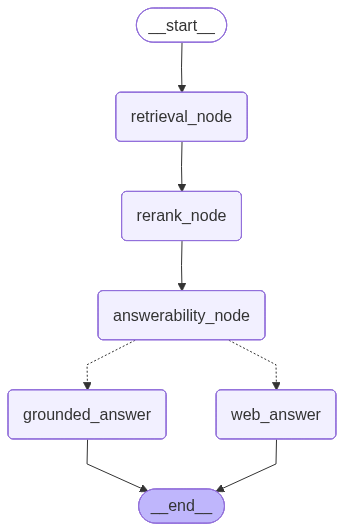

In [43]:
app

In [44]:
response = app.invoke({"question": "روزه برای چه افرادی واجب نیست؟"})

In [45]:
response

{'question': 'روزه برای چه افرادی واجب نیست؟',
 'retrieved_docs': [Document(id='4e337b58-b24f-4a41-87f8-919438dc80c9', metadata={}, page_content='ترک آن به صرف دشواری، ضعف جسمانی و مانند آن جایز نیست. بلی اگر برای آنها ضرر داشته و تحمل آن   \nبرای ایشان همراه مشقت زیاد باشد می توانند افطار کنند . ۵ .شرایط صحت روز ه  \n۱ .اسالم  \n۲ .ایمان \n۳ .عقل  \n۴ .بی هوش نبود ن  \n۵ .مسافر نبود ن  \n۶ .حایض و نفسا نبود  ن  \n۷ .ضرری نبود  ن  \n۸ .داشتن نی ت  \n۹ .ترک مفطرا ت  \n۰۱ .روزه ی قضا نداشتن (البته این شرط برای کسی است که می خواهد روزه ی مستحبی بگیرد). \nتوجه : \n روزه از افرادی صحیح است که واجد شرایط فوق باشند، بنابراین روزه ی کافر، دیوانه، بیهوش، مسافر،   \nحایض و نفسا، روزه یی که برای فرد ضرر دارد، یا در آن نیت روزه نکرده یا یکی از مفطرات را عمداً انجام  \nداده باطل است، همچنین روزه ی مستحبی کسی که روزه ی قضا دارد صحیح نیست. \n \n۶ .نیت روزه   \nالف) معنی و لزوم نی ت  \nروزه مانند همه  ی عبادتهای دیگر باید با نیت همراه باشد، بدین معنی که خودداری انسان از خوردن و  \nآشامیدن و سایر چیزها

In [47]:
print(response["final_answer"])

روزه برای افرادی مانند کودک نابالغ، دیوانه، بیهوش، فردی که توانایی گرفتن روزه ندارد، مسافر، زن حایض و نفسا، کسی که روزه برای او ضرر یا حرج (مشقت زیاد) دارد واجب نیست. (منبع: [1])


In [48]:
response2 = app.invoke({"question": "هوش مصنوعی چیست؟"})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18720\709780723.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results = 3)


In [49]:
response2

{'question': 'هوش مصنوعی چیست؟',
 'retrieved_docs': [Document(id='f2789780-a9f3-4409-a15e-35f7bb79c2c5', metadata={}, page_content='۱ .معنای روز ه  \n«    در شرع مقدس اسالم آن است که انسان در تمام روز (از طلوع فجر تا غروب آفتاب) با قصد اطاعت»روزه\nاز فرمان خداوند از خوردن و آشامیدن و چیزهای دیگری که به تفصیل گفته خواهد شد خودداری کند . \nتوجه: \n معیار شرعی در مورد وقت روزه، فجر صادق است نه کاذب، و احراز آن موکول به تشخیص مکلف است. \n در طلوع فجر (وقت وجوب امساک برای روزه گرفتن) فرقی بین شبهای مهتابی و غیر مهتابی نیست . \n  جهت رعایت احتیاط در امساک روزه، همزمان با  »اَیَّدَهُمُ اهللُ تَعَالی« مقتضی است که مؤمنین محترم\nشروع اذان صبح از رسانه ها برای روزه امساک نمایند . \n هرگاه برای روزه دار اطمینان حاصل شود که اذان از هنگام داخل شدن وقت شروع شده جایز است به  \nصرف شروع اذان، افطار نماید و صبر کردن تا پایان اذان الزم نیست. \n \n ۲ .انواع روز ه  \nروزه از یک نظر بر چهار نوع است: \n۱ .روزه ی واجب، مثل روز ه ی ماه مبارک رمضان. \n۲ .روزه ی مستحب، مثل روزهی ماه رجب و شعبان . \n۳ .روز ه ی م

In [50]:
print(response2["final_answer"])

    هوش مصنوعی (Artificial Intelligence) یا AI به فناوری می‌گویند که توانایی کارهایی مثل یادگیری، استدلال، تشخیص و حل مسئله را دارد که پیش از این فقط از عهده هوش انسانی برمی‌آمد و سیستم‌ها را قادر می‌سازد تا مانند انسان فکر و اقدام کنند.
